In [1]:
%reload_ext autoreload
%autoreload 2

import json
import os

import tqdm
import torch
import pyro
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyro.distributions as dist
from typing import Dict, Optional, NamedTuple

import mira
import mira.metamodel.io
import mira.modeling
import mira.modeling.viz
import mira.sources.petri

from pyciemss.ODE.askem_primitives import sample, infer_parameters, intervene, optimization
from pyciemss.ODE.base import ODE, PetriNetODESystem, Time, State, Solution, Observation, get_name
from pyciemss.utils import state_flux_constraint

pyro.settings.set(module_local_params=True)

In [2]:
class Scenario3Model(PetriNetODESystem):

    def __init__(self, G, *, noise_scale: float = 1):
        super().__init__(G)
        self.register_buffer("noise_scale", torch.as_tensor(noise_scale))
        for param in self.G.parameters.values():
            prior_loc = torch.log(torch.as_tensor(param.value if param.value is not None else 0.01))
            prior_scale = torch.as_tensor(0.1)
            setattr(self, get_name(param), pyro.nn.PyroSample(dist.LogNormal(prior_loc, prior_scale)))

    @pyro.nn.pyro_method
    def observation_model(self, solution: Solution, data: Optional[Dict[str, State]] = None) -> Solution:
        data = {} if data is None else data
        output = []
        for name, value in zip(self.var_order, solution):
            output.append(pyro.sample(
                name,
                pyro.distributions.Normal(value, self.noise_scale).to_event(1),
                obs=data.get(name, None),
            ))
        return tuple(output)


In [3]:
MODEL_PATH = "../../../program-milestones/6-month-milestone/evaluation/"

MODEL_FILES = {
    "biomd958": (
        os.path.join(MODEL_PATH, "scenario_3/ta_2/scenario3_biomd958.json"),
        os.path.join(MODEL_PATH, "scenario_3/ta_2/scenario3_biomd958_mira.json"),
    ),
    "biomd960": (
        os.path.join(MODEL_PATH, "scenario_3/ta_2/scenario3_biomd960.json"),
        os.path.join(MODEL_PATH, "scenario_3/ta_2/scenario3_biomd960_mira.json"),
    ),
    "sir": (
        os.path.join(MODEL_PATH, "scenario_1/ta_2/scenario1_sir.json"),
        os.path.join(MODEL_PATH, "scenario_1/ta_2/scenario1_sir_mira.json"),
    ),
}

DATA_ALIGNMENTS = {
    "biomd958": {
        "I": "Infectious",
        "H": "Hospitalised",
        "R": "Recovered",
        "D": "Fatalities",
    },
    "biomd960": {
        "I": "Infectious",
        "H": "Hospitalized",
        "R": "Recovered",
        "D": "Deceased",
    },
    "sir": {
        "I": "infected_population",
        "R": "immune_population",
    },
}

DATA_SCALE = {
    "biomd958": 1e3,
    "biomd960": 1.,
    "sir": 1e7,
}

def load_data(filename, model_name, interval: Optional[tuple] = None):
    df = pd.read_csv(filename)
    alignment = DATA_ALIGNMENTS[model_name]

    dates = pd.to_datetime(df["date"])
    
    if interval is not None:
        start, end = interval
        dates_mask = (dates >= start) & (dates <= end)

    tspan = torch.as_tensor(np.array(
        ((dates[dates_mask] if interval is not None else dates) - dates.iloc[0]).dt.total_seconds() / (24 * 60 * 60)
    ))

    obs = {
        alignment[col]: torch.tensor(
            (df[col][dates_mask] if interval is not None else df[col]).values
        ) / DATA_SCALE[model_name]
        for col in df.columns if col in alignment
    }

    return tspan, obs

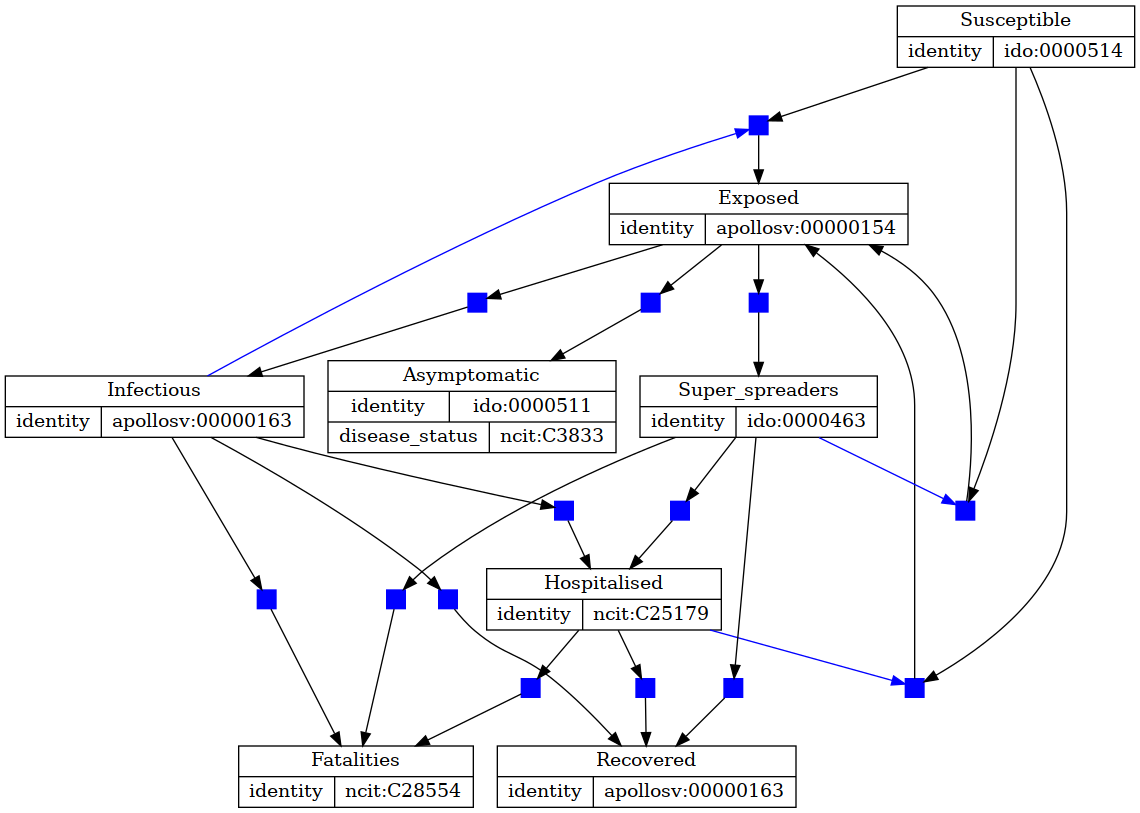

In [5]:
pyro.set_rng_seed(0)
pyro.clear_param_store()

MODEL_NAME = "biomd958"

DATA_FILE = "usa-IRDVHN_age.csv"
NUM_ITERATIONS = 500
OPTIM_PARAMS = {"lr": 1e-1}
TRAIN_INTERVAL = (pd.to_datetime("2021-06-01"), pd.to_datetime("2021-09-30"))
TEST_INTERVAL = (pd.to_datetime("2021-10-01"), pd.to_datetime("2022-01-01"))

model = Scenario3Model.from_mira(MODEL_FILES[MODEL_NAME][0])
model.noise_scale = pyro.nn.PyroSample(dist.LogNormal(0, 1))  #10. / DATA_SCALE[MODEL_NAME])

mira.modeling.viz.GraphicalModel.for_jupyter(model.G.template_model, name=f"viz_{MODEL_NAME}.png")

In [ ]:


initial_state = model.default_initial_state
full_tspan, full_data = load_data(DATA_FILE, MODEL_NAME)
train_tspan, train_data = load_data(DATA_FILE, MODEL_NAME, TRAIN_INTERVAL)
test_tspan, test_data = load_data(DATA_FILE, MODEL_NAME, TEST_INTERVAL)

for name, col in full_data.items():
    plt.plot(full_tspan, col, label=name)
plt.legend()
plt.title("Observed data")

print("Initial state: ", dict(zip(model.var_order, model.default_initial_state)))
pd.read_csv(DATA_FILE).describe()

In [25]:
NUM_ITERATIONS = 500

# posterior = infer_parameters(model, NUM_ITERATIONS, [], data, initial_state, tspan)
guide = pyro.infer.autoguide.AutoMultivariateNormal(pyro.poutine.block(model, hide=list(model.var_order.keys())))
loss_fn = pyro.infer.Trace_ELBO()(model, guide)

# initialize parameters
with torch.no_grad():
    loss_fn(initial_state, train_tspan, train_data)

optimizer = torch.optim.Adam(loss_fn.parameters(), **OPTIM_PARAMS)

for i in range(NUM_ITERATIONS):
    optimizer.zero_grad()
    loss = loss_fn(initial_state, train_tspan, train_data)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"iteration {i}: loss = {loss.item()}")

/home/eli/development/pyro/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'Recovered', 'Asymptomatic', 'Exposed', 'Susceptible'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


iteration 0: loss = 225318279315456.0
iteration 10: loss = 34097967661056.0
iteration 20: loss = 4169861955584.0
iteration 30: loss = 2339686580224.0
iteration 40: loss = 1422058717184.0
iteration 50: loss = 1239357718528.0
iteration 60: loss = 1051024687104.0
iteration 70: loss = 1189817483264.0
iteration 80: loss = 788902576128.0
iteration 90: loss = 769982595072.0
iteration 100: loss = 865732919296.0
iteration 110: loss = 785844666368.0
iteration 120: loss = 577965850624.0
iteration 130: loss = 633606832128.0
iteration 140: loss = 534172205056.0
iteration 150: loss = 615045791744.0
iteration 160: loss = 677307088896.0
iteration 170: loss = 383375802368.0
iteration 180: loss = 458313203712.0
iteration 190: loss = 452434264064.0
iteration 200: loss = 313034113024.0
iteration 210: loss = 321258815488.0
iteration 220: loss = 251877179392.0
iteration 230: loss = 217752322048.0
iteration 240: loss = 190698438656.0
iteration 250: loss = 292942053376.0
iteration 260: loss = 170260086784.0
i

Text(0.5, 1.0, "Posterior predictive distribution for model biomd960 (approx: <class 'pyro.infer.autoguide.guides.AutoMultivariateNormal'>)")

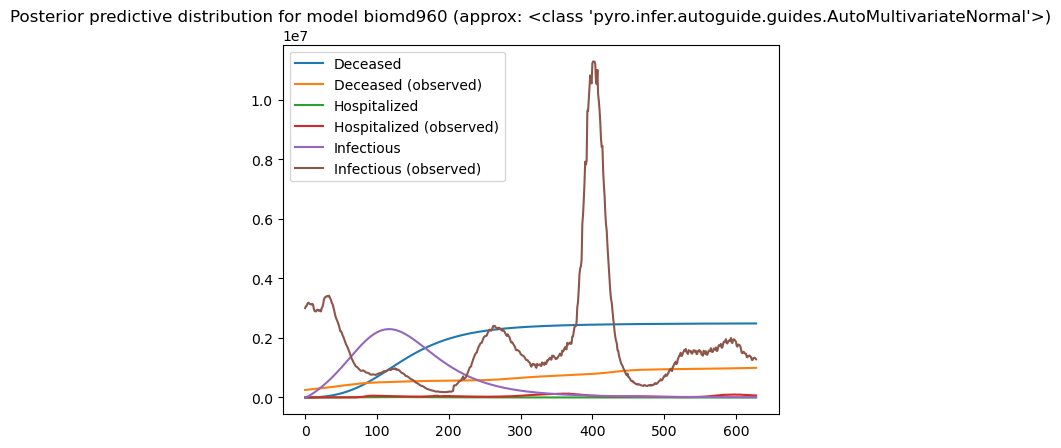

In [26]:
posterior_predictive = pyro.infer.Predictive(model, guide=guide, num_samples=100, return_sites=list(model.var_order.keys()))
result = posterior_predictive(initial_state, full_tspan)

for name in result.keys():
    if name in full_data:
        plt.plot(full_tspan, result[name].mean(0).detach().numpy(), label=name)
        plt.plot(full_tspan, full_data[name].detach().numpy(), label=name + " (observed)")
plt.legend()
plt.title(f"Posterior predictive distribution for model {MODEL_NAME} (approx: {type(guide)})")